In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mod_opt.data_load import *

#### functions

In [64]:
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import r2_score, mean_squared_error

def get_hyperparam_feat(df, index=0):
    '''
    Function to return hyperparameter config and selected features from dataframe of scores
    index =0 mean the hyperparameter for the highet r2_adj
    '''
    # Get the column names
    column_names = df.columns.tolist()

    # Find the index of 'r2_train'
    r2_train_index = column_names.index('num_features')

    # Select every column before 'r2_train'
    selected_columns = df.iloc[:, :r2_train_index]

    # Convert the DataFrame to a dictionary
    result_dict = selected_columns.to_dict('index')

    # Get the id of the best hyperparameter
    id = df.sort_values(by='r2_adj',ascending=False).index[index]

    # Get feature
    if type(df['selected_features'][id]) == str:
        df['selected_features'] = df['selected_features'].apply(ast.literal_eval)
    feat = df['selected_features'][id]
    return result_dict[id], feat

def plot_with_flight_num(predicted, actual, labels, title, plot_number=True, save_fig=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = 'o'  # circle
        elif str(flight_number).startswith('2022'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2023'):
            marker = 'x'  # x

        plt.scatter(actual[mask], predicted[mask], s=100, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=3)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def plot_with_flight_num2(predicted, actual, labels, title, std_dev = None, plot_number=False, save_fig=None, flt_to_plot=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        predicted = predicted[mask]
        actual = actual[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(actual[mask], predicted[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(actual[mask], predicted[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=2, fontsize=13)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate2(model, feat, labels, title, plt_num=True, save_fig=None, flt_to_plot=None):
    print('Train score: ',model.score(X_train_norm[feat],y_train), ' RMSE:',mean_squared_error(y_train, model.predict(X_train_norm[feat]), squared=False))
    print('Validation score: ',model.score(X_val_norm[feat],y_val), ' RMSE:',mean_squared_error(y_val, model.predict(X_val_norm[feat]), squared=False))
    print('Test score: ',model.score(X_test_norm[feat],y_test), ' RMSE:',mean_squared_error(y_test, model.predict(X_test_norm[feat]), squared=False))

    plot_with_flight_num2(model.predict(X_test_norm[feat])*100,y_test*100,labels, title=title, plot_number=plt_num,save_fig=save_fig, flt_to_plot=flt_to_plot)

def evaluate_model_by_flight_combined(model, feat, X, y, labels_):
    # This function evaluates a given model's performance by flight group. It calculates R-squared 
    # and RMSE metrics for the combined dataset for each unique flight group in the dataset. 
    # The function requires the model, features (feat), and labels containing flight information. 
    # It returns a DataFrame with flight groups as the index and the evaluation metrics for each dataset.
    
    labels = labels_.copy()  # Copy labels to avoid modifying the original DataFrame
    results = []  # Initialize results list
    labels['FlightGroup'] = labels['Flight'].astype(str).str[:4]  # Extract the first four digits of the 'Flight' column
    unique_flight_groups = labels['FlightGroup'].unique()  # Get unique flight groups from labels

    for flight_group in unique_flight_groups:  # Iterate over each unique flight group
        # Filter datasets for the current flight group
        mask = labels['FlightGroup'] == flight_group
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))

        # Append the results
        results.append({
            'FlightGroup': flight_group,
            '$R^2$': r2_combined,
            'RMSE (%)': rmse_combined
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('FlightGroup', inplace=True)
    
    return results_df


In [40]:
def evaluate_model_by_flight_combined(model, feat, X, y, labels_):
    # This function evaluates a given model's performance by flight group. It calculates R-squared 
    # and RMSE metrics for the combined dataset for each unique flight group in the dataset. 
    # The function requires the model, features (feat), and labels containing flight information. 
    # It returns a DataFrame with flight groups as the index and the evaluation metrics for each dataset.
    
    labels = labels_.copy()  # Copy labels to avoid modifying the original DataFrame
    results = []  # Initialize results list
    
    # Create a new column to group 2021 and 2022 together, and keep 2023 separate
    labels['FlightGroup'] = labels['Flight'].astype(str).str[:4].replace({'2021': '2021-2022', '2022': '2021-2022'})
    
    unique_flight_groups = labels['FlightGroup'].unique()  # Get unique flight groups from labels

    for flight_group in unique_flight_groups:  # Iterate over each unique flight group
        # Filter datasets for the current flight group
        mask = labels['FlightGroup'] == flight_group
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))

        # Append the results
        results.append({
            'FlightGroup': flight_group,
            '$R^2$': r2_combined,
            'RMSE (%)': rmse_combined
        })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('FlightGroup', inplace=True)
    
    return results_df

## RF

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.8936308653091674  RMSE: 0.06923516415670579
Validation score:  0.870722343123187  RMSE: 0.08094402100116532
Test score:  0.8212898350870208  RMSE: 0.09307135641089022


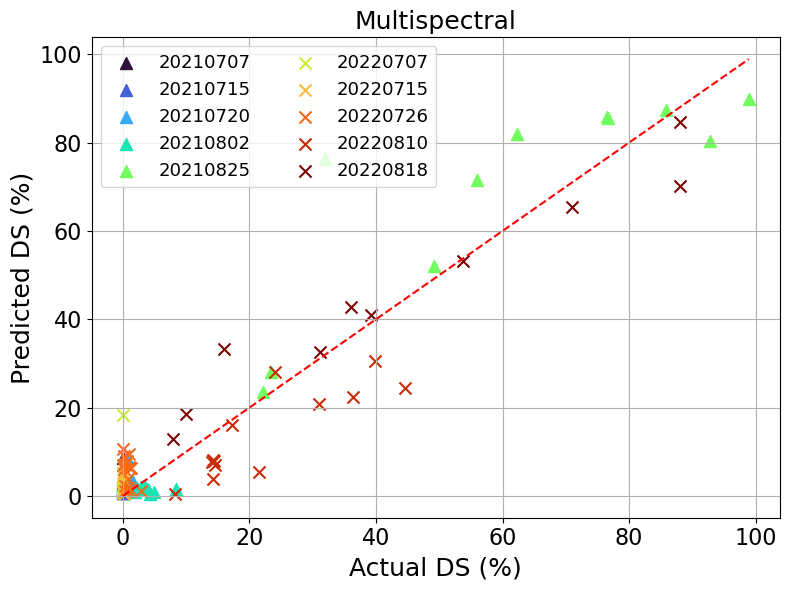

In [66]:
from sklearn.ensemble import RandomForestRegressor

result_rf = pd.read_csv('mod_opt/model_scores/rf_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_rf, index=0)

model = RandomForestRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='Multispectral', plt_num=False, flt_to_plot=[20210707, 20210715, 20210720, 20210802, 20210825, 20220707, 20220715, 20220726, 20220810, 20220818])#, save_fig='figures/RF_test.png')

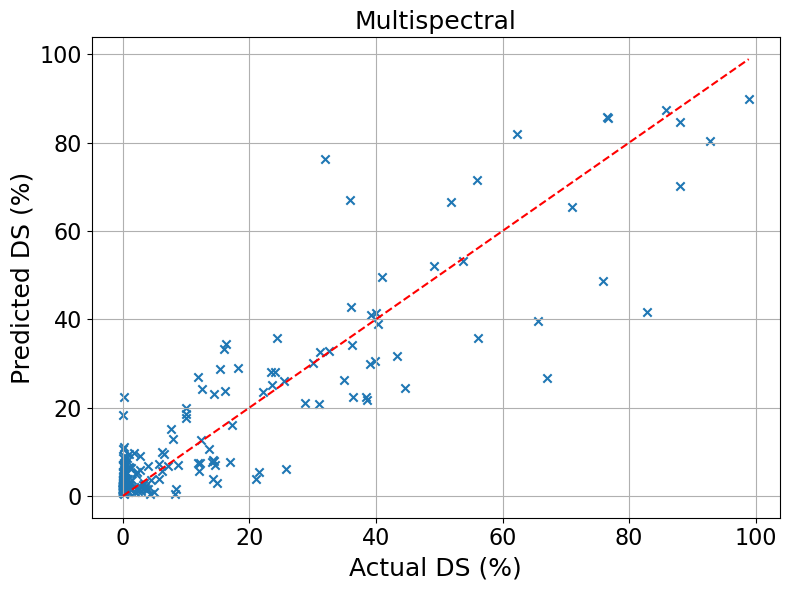

In [69]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test*100,model.predict(X_test_norm[feat])*100, marker = 'x')
plt.plot([min(y_test*100), max(y_test*100)], [min(y_test*100), max(y_test*100)], color='red', linestyle='--')
plt.xlabel('Actual DS (%)', fontsize=18)
plt.ylabel('Predicted DS (%)', fontsize=18)
plt.title('Multispectral', fontsize=18)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
plt.tight_layout()
plt.show()

In [20]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_val_norm, y_val, labels_val))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.939703  0.060192
2023         0.733491  0.080127
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.701445  0.099005
2021-2022    0.951677  0.057461
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.613566  0.122270
2021-2022    0.901458  0.071822


In [52]:
# just micasense
model_evaluate2(model, feat, labels_test, title='GPR', X_train=X_train_norm, y_train=y_train, X_test=X_test_norm, y_test=y_test, err_bar=False, plt_num=False, flt_to_plot=[20210707, 20210715, 20210720, 20210802, 20210825, 20220707, 20220715, 20220726, 20220810, 20220818])#, save_fig='figures/GPR_test.png')

TypeError: predict() got an unexpected keyword argument 'return_std'

In [ ]:
from preprocess_hyper.prep_func import *
import pickle

zipped_im21_22 = pickle.load(open('data/ziped_21_22.pkl', 'rb'))
zipped_im23 = pickle.load(open('data/ziped_23.pkl', 'rb'))
# Create a list of functions to apply to the images
def max_min(image):
    ratio = image.max() / (image.min()+0.0001)
    return np.where(ratio > 30, np.nan, ratio)
functions = [(np.linalg.norm, {'axis': 2}),
             (max_min, {})]

# Apply the functions to the images
d_range_m = pd.DataFrame(apply_functions_to_images({**zipped_im21_22, **zipped_im23}, functions))
Dr_m = pd.Series(np.nanmean(d_range_m, axis=0), index=d_range_m.columns)

In [10]:
import pandas as pd

def create_err_matrix(model, X_scaled, y, labels, feat):
    # Predict with the model
    pred = model.predict(X_scaled[feat])
    
    # Calculate the error
    err = pred - y
    
    # Create a copy of the labels DataFrame
    err_matrix = labels.copy()
    
    # Append the error to the labels DataFrame
    err_matrix['err'] = err
    
    return err_matrix

# Create the error matrix for the RF model
err_matrix_rf_test = create_err_matrix(model, X_test_norm, y_test, labels_test, feat)
err_matrix_rf = create_err_matrix(model, 
                                  pd.concat([X_train_norm, X_val_norm, X_test_norm]), 
                                  pd.concat([y_train, y_val, y_test]), 
                                  pd.concat([labels_train, labels_val, labels_test]), 
                                  feat)
rmse_m = err_matrix_rf.groupby('Flight')['err'].apply(lambda x: np.sqrt(np.nanmean(x**2)))

<Axes: ylabel='Flight'>

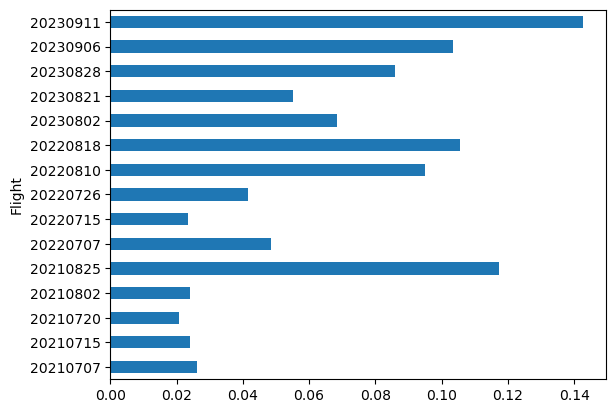

In [12]:
rmse_m.plot.barh()

<Axes: >

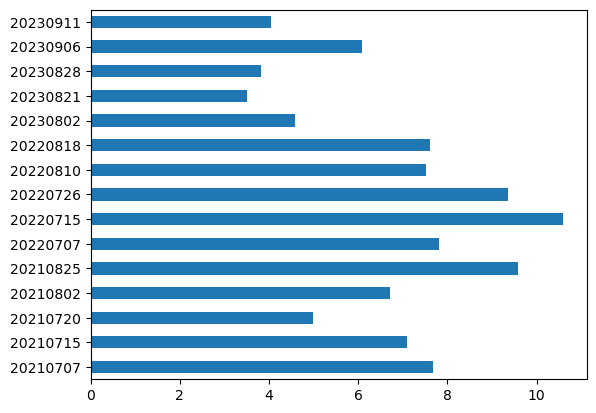

In [14]:
Dr_m.plot.barh()

Text(0, 0.5, 'RMSE')

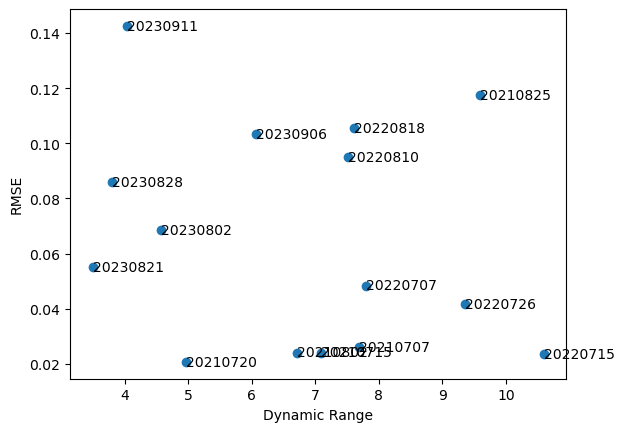

In [15]:
plt.scatter(Dr_m, rmse_m)
for i, txt in enumerate(Dr_m.index):
    plt.annotate(txt, (Dr_m.iloc[i], rmse_m.iloc[i]), fontsize=10, va='center')
plt.xlabel('Dynamic Range')
plt.ylabel('RMSE')

In [16]:

def add_dynamic_range(err_matrix, DR):
    """
    Add a "Dynamic Range" column to the err_matrix based on the 'Flight' and 'Plot' columns.

    Parameters:
    - err_matrix (pd.DataFrame): The input DataFrame containing 'Flight' and 'Plot' columns.
    - DR (pd.DataFrame): The DataFrame containing the "Dynamic Range" values.

    Returns:
    - err_matrix (pd.DataFrame): The updated DataFrame with the "Dynamic Range" column added.
    """
    # Check if 'Flight' and 'Plot' columns exist in err_matrix
    if 'Flight' not in err_matrix.columns or 'Plot' not in err_matrix.columns:
        raise ValueError("The 'Flight' and 'Plot' columns must be present in the err_matrix.")

    # Initialize an empty list to store the "Dynamic Range" values
    dynamic_range_values = []

    # Iterate over the rows of the err_matrix
    for _, row in err_matrix.iterrows():
        flight = str(int(row['Flight']))
        plot = row['Plot']
        # Retrieve the corresponding "Dynamic Range" value from the DR matrix
        dynamic_range_value = DR.at[plot, flight]
        dynamic_range_values.append(dynamic_range_value)

    # Add the "Dynamic Range" values to the err_matrix
    err_matrix['Dynamic Range'] = dynamic_range_values

    return err_matrix
#DR_m = pd.DataFrame(d_range_m)
#DR_h = pd.DataFrame(d_range_h)

add_dynamic_range(err_matrix_rf, d_range_m)

,Flight,Plot,err,Dynamic Range
152,20210802,3,-0.047266,6.988147878701761
365,20220818,15,0.197591,8.633492504138955
200,20230906,3,0.095652,6.916099566278004
216,20230906,54,-0.048465,5.631055442408569
221,20220707,2,0.063161,8.345510719639142
...,...,...,...,...
227,20220707,35,0.013770,6.886685228493507
281,20220726,11,0.088292,9.37935629863206
4,20230802,14,0.071091,3.6361841256609813
177,20210825,26,0.015941,8.344018000320357


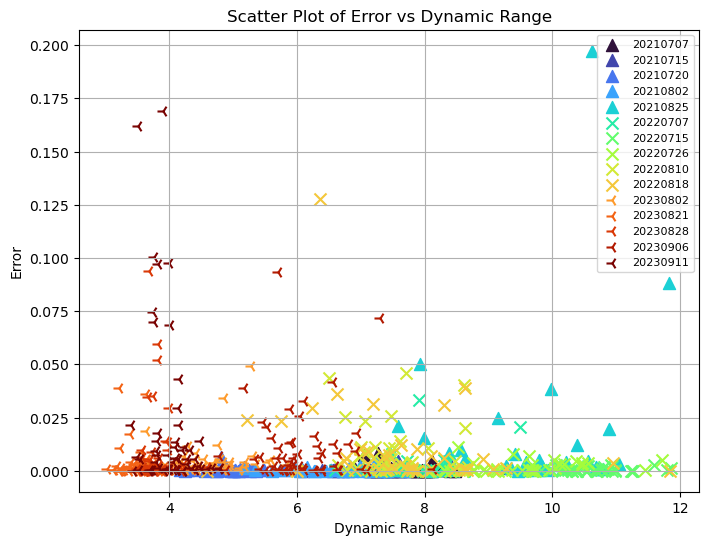

In [17]:
## Plotting the error vs dynamic range (all points)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_err_vs_dynamic_range(err_matrix_in, err_std='err', flt_to_plot = None, std_dev = None, plot_number = False):
    """
    Plot a scatter plot of 'err' vs 'Dynamic Range' with different types of points based on 'Flight'.

    Parameters:
    - err_matrix (pd.DataFrame): The input DataFrame containing 'err', 'Dynamic Range', and 'Flight' columns.
    """
    err_matrix = err_matrix_in.copy()
     # Extract the 'Flight' column
    flight_column = err_matrix['Flight']
    plot_column = err_matrix['Plot']

    err_y = err_matrix[err_std]**2
    err_x = err_matrix['Dynamic Range'] 
    
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        err_y = err_y[mask]
        err_x = err_x[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]
    
    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)
    # Create a scatter plot using seaborn
    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(err_x[mask], err_y[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(err_x[mask], err_y[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(err_x.iloc[i], err_y[i], f'{plot_num}', fontsize=10, ha='right') 
    # Set labels and title
    plt.xlabel('Dynamic Range')
    plt.ylabel('Error')
    plt.title('Scatter Plot of Error vs Dynamic Range')
    plt.grid(True)
    
    # Clip the x-axis to a specific range
    #plt.xlim(2, 15)

    plt.legend(loc = 'upper right', ncol=1, fontsize=8)
    
    # Show the plot
    plt.show()
plot_err_vs_dynamic_range(err_matrix_rf)

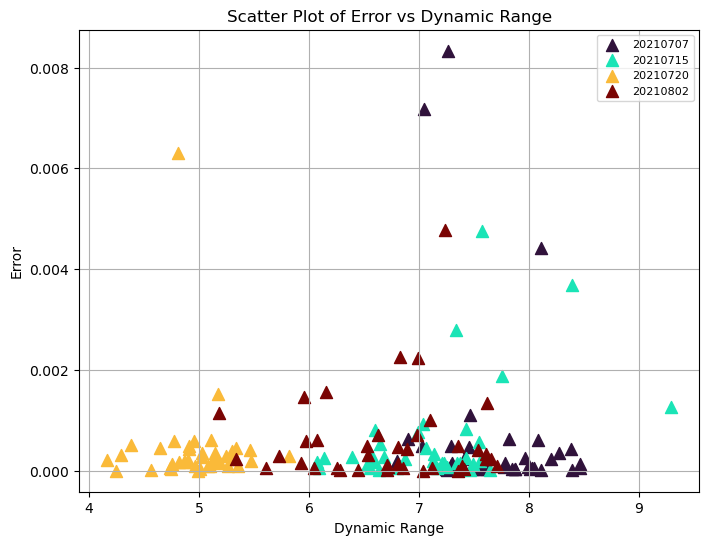

In [20]:
plot_err_vs_dynamic_range(err_matrix_rf, flt_to_plot=[20210707, 20210715, 20210720, 20210802])#, 20210825])

## XGBoost

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.9250440377961859  RMSE: 0.05811951812777224
Validation score:  0.8856709010695105  RMSE: 0.0761204643777621
Test score:  0.8078434381045663  RMSE: 0.09650926882920632


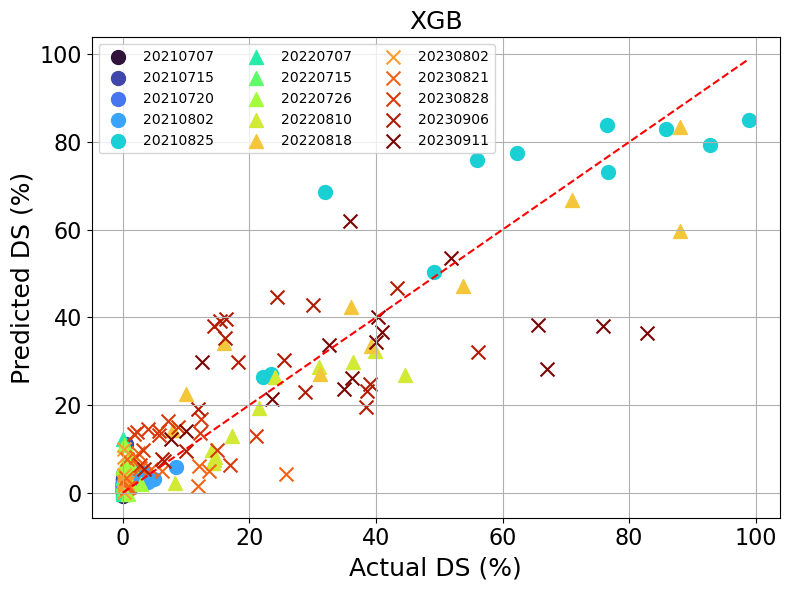

In [31]:
import xgboost as xgb

result_xgb = pd.read_csv('mod_opt/model_scores/xgb_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_xgb, index=0)

model = xgb.XGBRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat,labels_test, title='XGB', plt_num=False)#, save_fig='figures/XGB_test.png')

In [24]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.966615  0.044789
2023         0.780629  0.072696
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.526771  0.135307
2021-2022    0.917814  0.065591


## SVR

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.8750461438037025  RMSE: 0.0750401588679102
Validation score:  0.8067473699418808  RMSE: 0.09896593800694084
Test score:  0.7822844651365088  RMSE: 0.10272735943867563


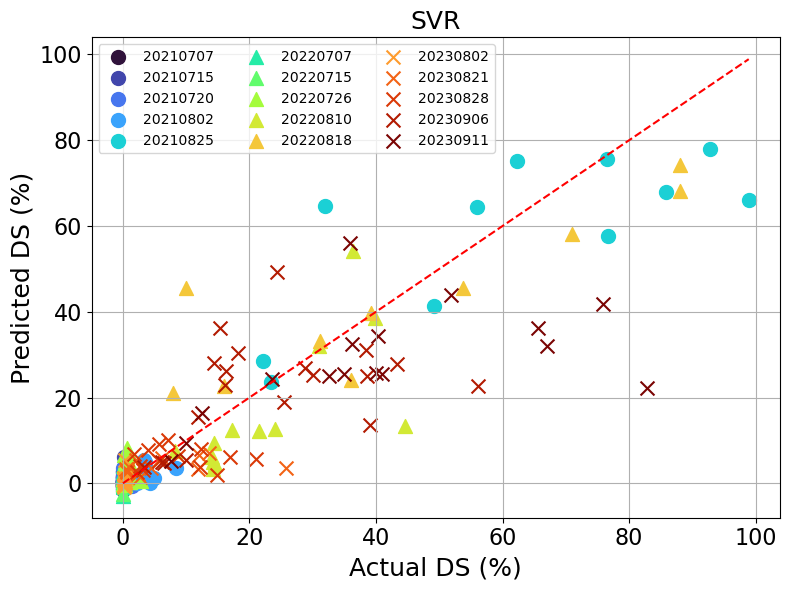

In [25]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

result_svr = pd.read_csv('mod_opt/model_scores/svr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_svr, index=0)

model = SVR(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='SVR', plt_num=False)#, save_fig='figures/SVR_test.png')

In [26]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.954011  0.052568
2023         0.600796  0.098066
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.528357  0.135080
2021-2022    0.880306  0.079156


## PLSR

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.7631890713712791  RMSE: 0.10330462928085933
Validation score:  0.827123630166636  RMSE: 0.09360323443318556
Test score:  0.7865165505555299  RMSE: 0.1017240215621344


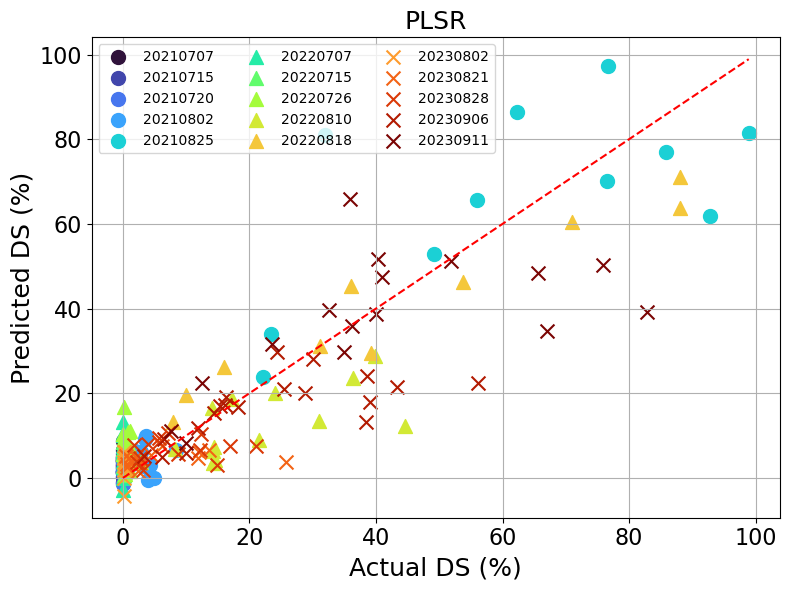

In [27]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

result_plsr = pd.read_csv('mod_opt/model_scores/plsr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_plsr, index=0)
hyperparameters ={'n_components': 5} # to avoid n_component > n_feature error
model = PLSRegression(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='PLSR', plt_num=False)#, save_fig='figures/PLSR_test.png')

In [28]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.841911  0.097464
2023         0.489344  0.110913
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.656290  0.115313
2021-2022    0.833721  0.093296


## MLP

c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ms4667\.conda\envs\geo_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train score:  0.8566425006092733  RMSE: 0.0803765056783278
Validation score:  0.8540943310228567  RMSE: 0.08599221224823358
Test score:  0.8140402750111061  RMSE: 0.09494035759065081


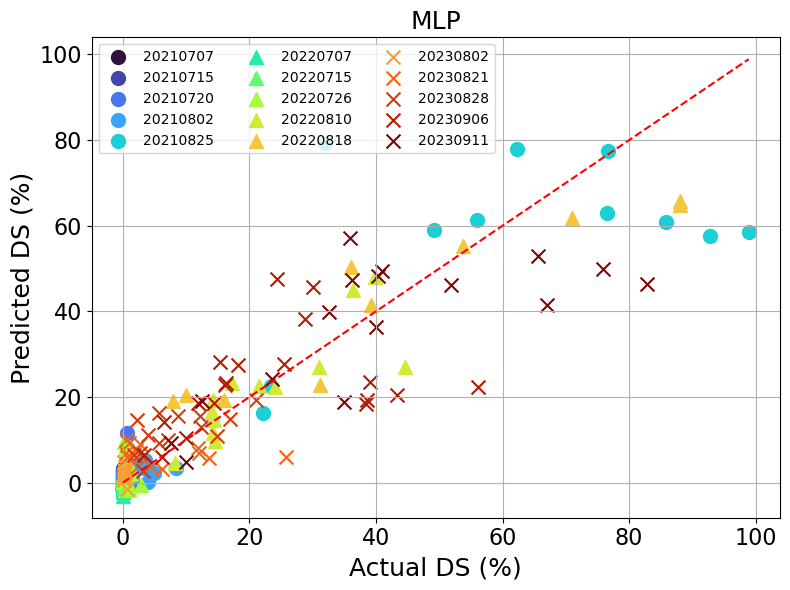

In [11]:
from sklearn.neural_network import MLPRegressor

result_mlp = pd.read_csv('mod_opt/model_scores/mlp_scores_micorfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_mlp, index=0)

# Convert hidden_layer_sizes to a tuple if it is a string
if isinstance(hyperparameters['hidden_layer_sizes'], str):
	hyperparameters['hidden_layer_sizes'] = ast.literal_eval(hyperparameters['hidden_layer_sizes'])

model = MLPRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='MLP', plt_num=False)#, save_fig='figures/mlp_test.png')

In [8]:
hyperparameters

{'hidden_layer_sizes': (150, 100, 50, 25, 10, 5),
 'activation': 'relu',
 'solver': 'adam',
 'alpha': 0.05,
 'learning_rate': 'adaptive',
 'max_iter': 200,
 'random_state': 42}

In [14]:
feat

['rdvi_skewness',
 'mcariosavi_q3',
 'mcariosavi_skewness',
 'ref_mean_1',
 'ref_q1_2',
 'ref_q3_3',
 'ref_skewness_1',
 'ref_skewness_3',
 'tex_dis_cv_1',
 'tex_mean_q3_1',
 'tex_mean_skewness_4',
 'tex_var_kurtosis_4',
 'tex_cor_cv_3',
 'tex_cor_cv_4',
 'tex_cor_q3_4']

In [11]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.907972  0.074362
2023         0.678130  0.088056
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.670500  0.112904
2021-2022    0.867556  0.083265


## GPR

In [58]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error # type: ignore

def gaussian_process_regression_with_tuning(X_train, y_train, X_test, y_test, print_results=True):
    """
    Perform Gaussian Process Regression with hyperparameter tuning on the given training data,
    and predict the output for the test data.

    Parameters:
    - X_train: Training features.
    - y_train: Training targets.
    - X_test: Test features to predict.

    Returns:
    - y_pred: Predicted values for X_test.
    - model: The fitted Gaussian Process Regressor model with the best found hyperparameters.
    """
    # Define different kernel functions
    kernels = [
        C(1.0, (1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3)),
        #C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.5),
        #C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), alpha=0.1),
        #C(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), periodicity=3.0),
        #C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))
    ]
    
    # Setup hyperparameter space for tuning
    param_grid = {
        "alpha": [0.05, 0.1, 0.5, 1],
        "kernel": kernels
    }
    # Instantiate a Gaussian Process Regressor
    gpr = GaussianProcessRegressor(n_restarts_optimizer=10)
    
    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(gpr, param_grid=param_grid, cv=5, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Best model after tuning
    model = grid_search.best_estimator_
    
    # Make predictions using the best found model
    #y_pred = model.predict(X_test)
    if print_results:
        print(f'Model score: {model.score(X_test,y_test)}')
    return model, grid_search

from tkinter import font
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
import ast

def plot_with_flight_num(predicted, actual, labels, title, std_dev = None, plot_number=False, save_fig=None, flt_to_plot=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']
    # Filter data if flt_to_plot is provided
    if flt_to_plot is not None:
        mask = flight_column.isin(flt_to_plot)
        predicted = predicted[mask]
        actual = actual[mask]
        if std_dev is not None:
            std_dev = std_dev[mask]
        flight_column = flight_column[mask]
        plot_column = plot_column[mask]

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2022'):
            marker = 'x'  # x
        elif str(flight_number).startswith('2023'):
            marker = '3'  # y
        else:
            marker = 'o'  # circle
        
        plt.scatter(actual[mask], predicted[mask], s=75, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)
        # If standard deviation is provided, plot confidence intervals
        if std_dev is not None:
            # Calculate the 95% confidence interval, assuming normal distribution
            ci = 1.96 * std_dev[mask]
            plt.errorbar(actual[mask], predicted[mask], yerr=ci, fmt='none', ecolor=color_map(i/len(unique_flights)), alpha=1, elinewidth=1, capsize=5)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=2, fontsize=13)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate2(model, feat, labels, title, X_train, y_train, X_test, y_test, err_bar=False, plt_num=False, save_fig=None, flt_to_plot=None):
    _,train_std = model.predict(X_train[feat], return_std=True)
    predicted_mean, predicted_std = model.predict(X_test[feat], return_std=True)
    print('Train score: ',model.score(X_train[feat],y_train), ' RMSE:',root_mean_squared_error(y_train, model.predict(X_train[feat])), ' MAPE:',mean_absolute_percentage_error(y_train, model.predict(X_train[feat])), ' std_dev:',train_std.mean())
    #print('Validation score: ',model.score(X_val[feat],y_val), ' RMSE:',mean_squared_error(y_val, model.predict(X_val[feat]), squared=False))
    print('Test score: ',model.score(X_test[feat],y_test), ' RMSE:',root_mean_squared_error(y_test, model.predict(X_test[feat])), ' MAPE:',mean_absolute_percentage_error(y_test, model.predict(X_test[feat])), ' std_dev:',predicted_std.mean())

    if err_bar:
        plot_with_flight_num(predicted_mean, y_test, labels, title=title, std_dev=predicted_std, plot_number=plt_num, save_fig=save_fig, flt_to_plot=flt_to_plot)
    else:
        plot_with_flight_num(model.predict(X_test[feat]),y_test,labels, title=title, plot_number=plt_num,save_fig=save_fig,flt_to_plot=flt_to_plot)

def evaluate_model_by_flight_combined(model, feat, X, y, labels, rmse= False, std=False):
    # This function evaluates a given model's performance by flight. It calculates R-squared 
    # and RMSE metrics for training, validation, and test datasets separately for each 
    # unique flight in the dataset. The function requires the model, features (feat), and 
    # labels containing flight information. It returns a DataFrame with flights as the 
    # index and the evaluation metrics for each dataset.
    results = []  # Initialize results list
    unique_flights = labels['Flight'].unique()  # Get unique flights from labels

    for flight in unique_flights:  # Iterate over each unique flight
        # Filter datasets for the current flight
        mask = labels['Flight'] == flight
        X_flt, y_flt = X[mask], y[mask]

        # Calculate scores and RMSE for the combined dataset
        r2_combined = model.score(X_flt[feat], y_flt)
        rmse_combined = np.sqrt(mean_squared_error(y_flt, model.predict(X_flt[feat])))
        mape_combined = mean_absolute_percentage_error(y_flt, model.predict(X_flt[feat]))

        # Append the results
        results.append({
            'Flight': flight,
            '$R^2$': r2_combined,
            'MAPE (%)': mape_combined*100
        })
        if rmse:
            results[-1]['RMSE ($kg/m^2$)'] = rmse_combined
        if std:
            _, predicted_std = model.predict(X_flt[feat], return_std=True)
            results[-1]['std_dev ($kg/m^2$)'] =  predicted_std.mean()

    # Return the results as a DataFrame with 'Flight' as the index
    df = pd.DataFrame(results)
    df.set_index('Flight', inplace=True)
    return df

In [59]:
model, grid_search = gaussian_process_regression_with_tuning(X_train_norm[feat], y_train, X_val_norm[feat], y_val)

Model score: 0.8602733428623536


Train score:  0.7687124440509915  RMSE: 0.10209278392196472  MAPE: 19602755489965.164  std_dev: 0.023799119912161056
Test score:  0.8063469263613281  RMSE: 0.09688434617031756  MAPE: 30021639527422.082  std_dev: 0.02497874471635467


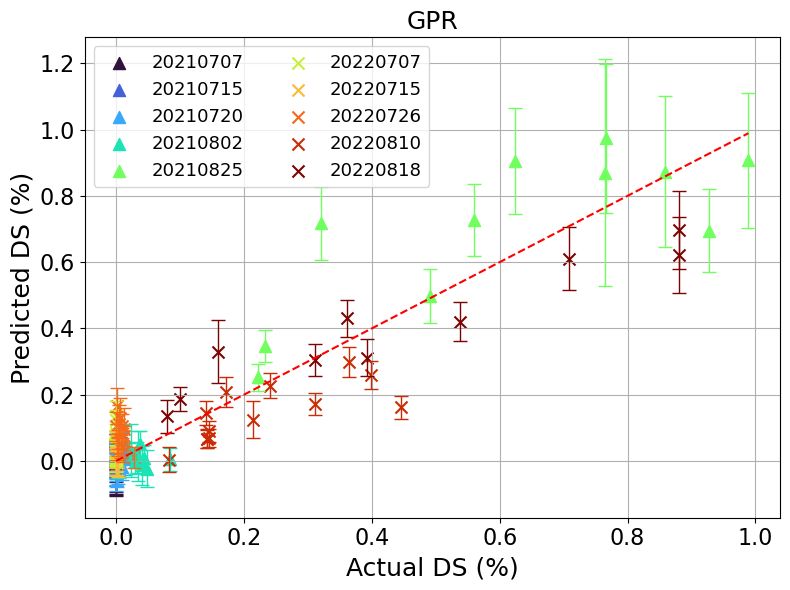

In [61]:
model_evaluate2(model, feat, labels_test, title='GPR', X_train=X_train_norm, y_train=y_train, X_test=X_test_norm, y_test=y_test, err_bar=True, plt_num=False, flt_to_plot=[20210707, 20210715, 20210720, 20210802, 20210825, 20220707, 20220715, 20220726, 20220810, 20220818])#, save_fig='figures/GPR_test.png')

In [44]:
print(evaluate_model_by_flight_combined(model, feat, X_train_norm, y_train, labels_train))
print(evaluate_model_by_flight_combined(model, feat, X_val_norm, y_val, labels_val))
print(evaluate_model_by_flight_combined(model, feat, X_test_norm, y_test, labels_test))

                $R^2$  RMSE (%)
FlightGroup                    
2021-2022    0.867660  0.089174
2023         0.424771  0.117717
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.705373  0.098352
2021-2022    0.934289  0.067007
                $R^2$  RMSE (%)
FlightGroup                    
2023         0.653378  0.115801
2021-2022    0.863515  0.084526
